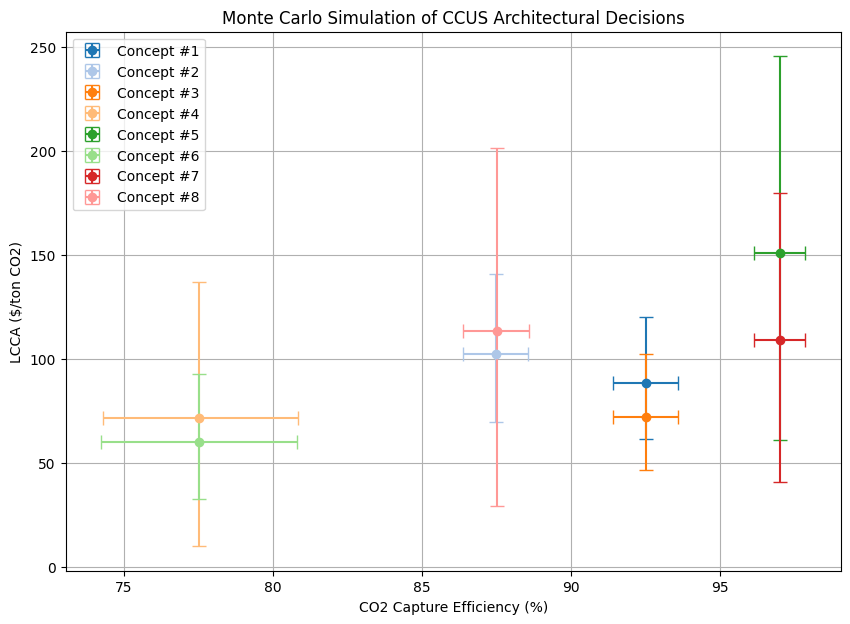

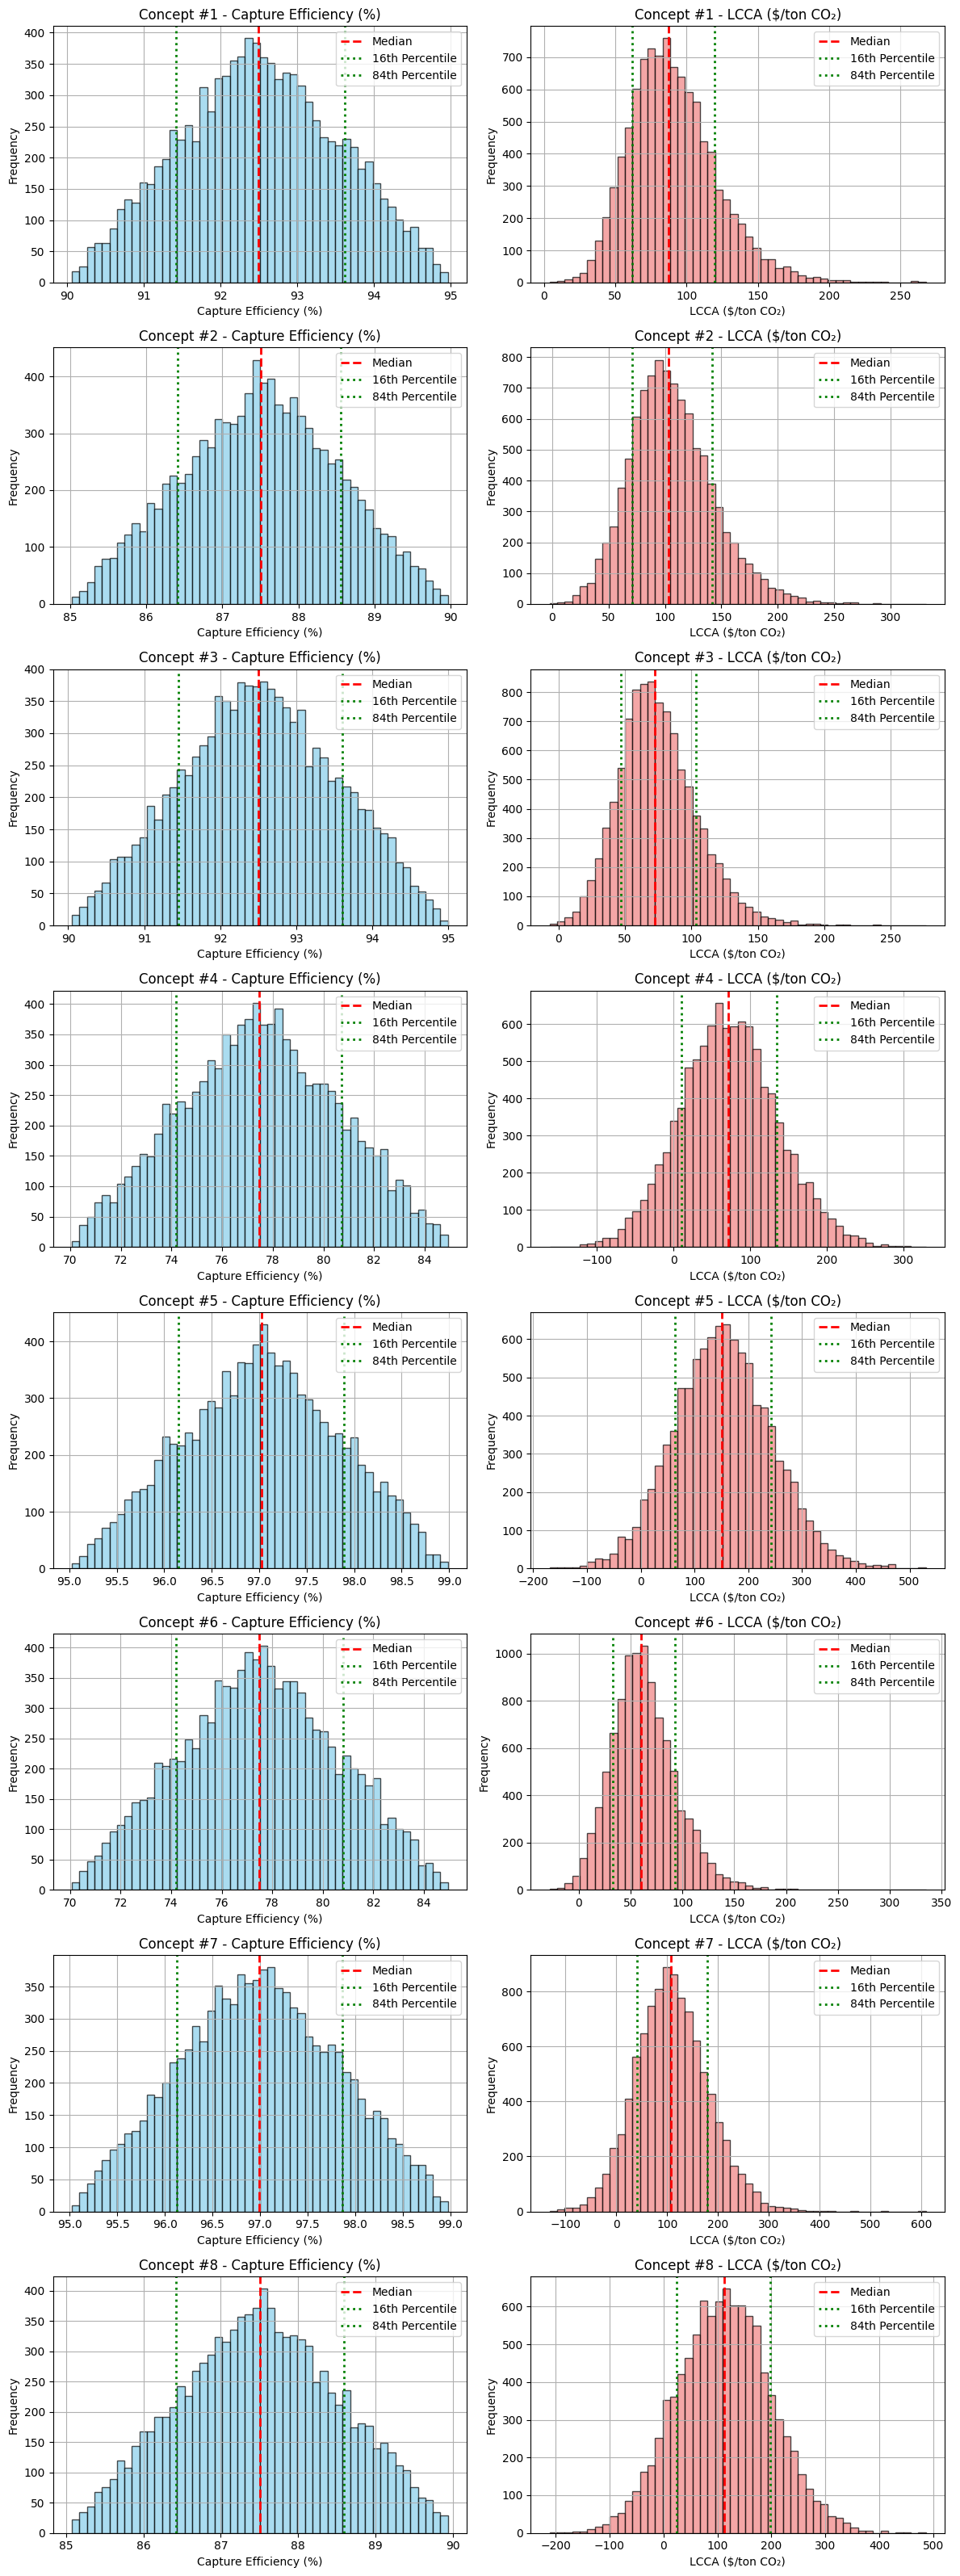

/tmp/ipykernel_18352/3380690849.py:379: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10', len(concepts))


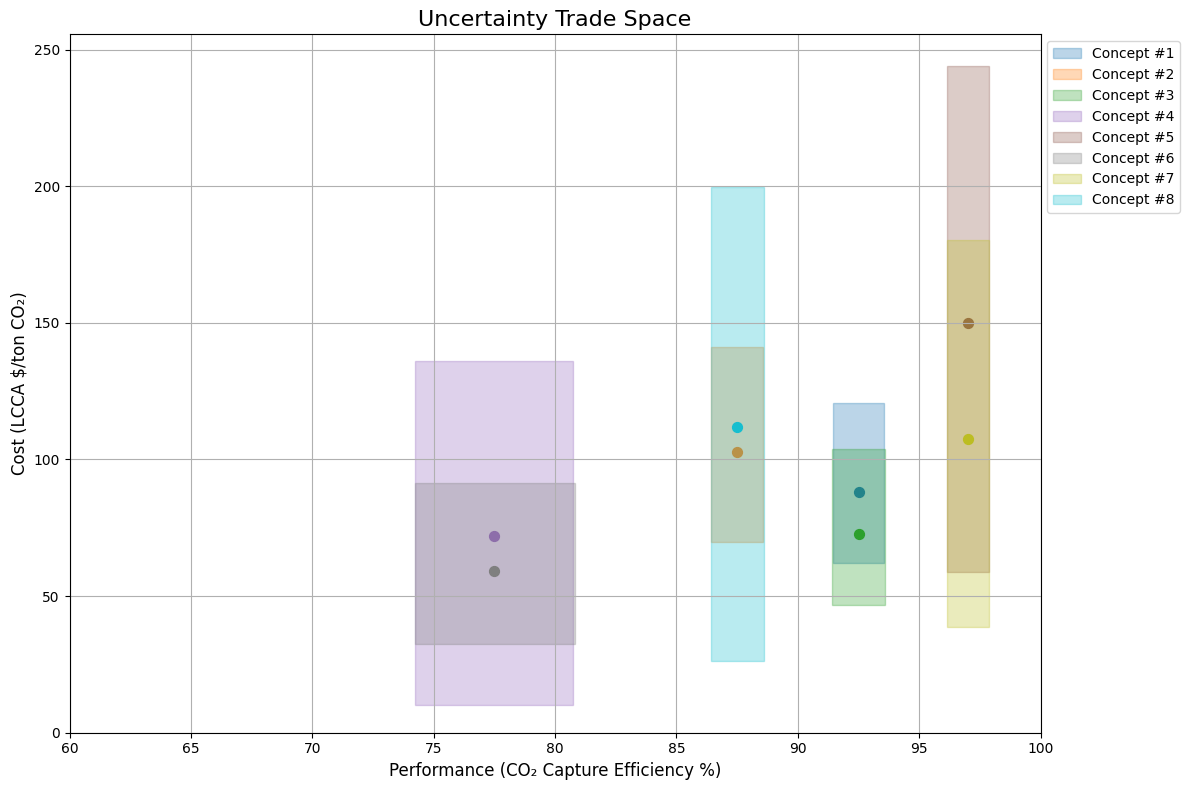

/tmp/ipykernel_18352/3380690849.py:432: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10', len(concepts))


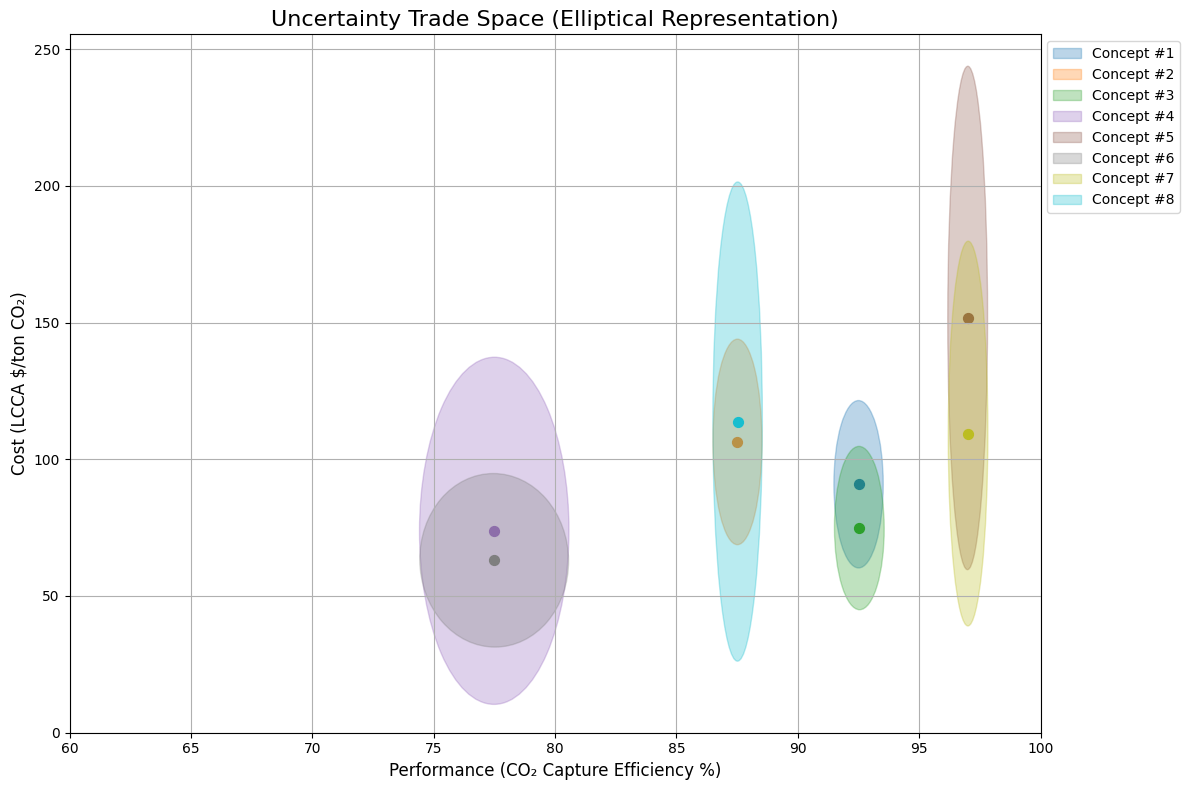

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import itertools
from scipy.interpolate import interp1d
import matplotlib.patches as patches

# Set the number of Monte Carlo samples
N = 10000

def simulate_architecture(base_eff, tri_left, tri_mode, tri_right, base_cost, ad1_mu, ad1_std, ln_mean, ln_sigma):

    """
    Simulate an architecture using distributions for uncertainty in the architectural decisions:
    - AD2 (CO2 Capture Method): Simulate CO2 capture efficiency using a triangular distribution
    (parameters: left limit, mode, right limit).
    - AD1 (CO2 Source Composition): Simulate the impact on LCCA using a normal distribution.
    - AD3 to AD5: Simulate additional cost contributions from these decisions using lognormal distributions,
    which capture the long right-tail characteristic of cost estimates.

    The final LCCA is computed as:
     LCCA = base_cost + (AD1 effect) + (AD3 + AD4 + AD5 cost contributions)
    """
    # AD2: Generate CO2 capture efficiency (fraction between 0 and 1) using a triangular distribution
    capture_eff = np.random.triangular(tri_left, tri_mode, tri_right, N)
    
    # AD1: Generate the shift in LCCA due to the CO2 source composition using a normal distribution (unit: $/ton CO2)
    ad1_effect = np.random.normal(ad1_mu, ad1_std, N)
    
    # AD3 to AD5: Generate additional cost contributions using a lognormal distribution to capture the long right tail
    ad3_cost = np.random.lognormal(mean=ln_mean, sigma=ln_sigma, size=N)
    ad4_cost = np.random.lognormal(mean=ln_mean, sigma=ln_sigma, size=N)
    ad5_cost = np.random.lognormal(mean=ln_mean, sigma=ln_sigma, size=N)
    
    # Calculate the overall LCCA as the sum of the base cost, AD1 effect, and additional costs (AD3, AD4, AD5)
    LCCA = base_cost + ad1_effect + (ad3_cost + ad4_cost + ad5_cost)
    return capture_eff, LCCA

def simulate_architecture_byADs(base_cost, AD1, AD2, AD3, AD4, AD5):

    # AD2: Generate CO2 capture efficiency (fraction between 0 and 1) using a triangular distribution
    capture_eff = np.random.triangular(AD2.capture_efficiency_left, AD2.capture_efficiency_mode, AD2.capture_efficiency_right, N)
    
    # AD1: Generate the shift in LCCA due to the CO2 source composition using a normal distribution (unit: $/ton CO2)
    ad1_effect = np.random.normal(AD1.cost, AD1.cost_err, N)
    
    # AD3 to AD5: Generate additional cost contributions using a lognormal distribution to capture the long right tail
    ad2_cost = np.random.lognormal(mean=AD2.ln_mu(), sigma=AD2.ln_sigma(), size=N) if AD2.ln_mu()>0 else 0
    ad3_cost = np.random.lognormal(mean=AD3.ln_mu(), sigma=AD3.ln_sigma(), size=N) if AD3.ln_mu()>0 else 0
    ad4_cost = np.random.lognormal(mean=AD4.ln_mu(), sigma=AD4.ln_sigma(), size=N) if AD4.ln_mu()>0 else 0
    ad5_cost = np.random.lognormal(mean=AD5.ln_mu(), sigma=AD5.ln_sigma(), size=N) if AD5.ln_mu()>0 else 0
    
    # Calculate the overall LCCA as the sum of the base cost, AD1 effect, and additional costs (AD3, AD4, AD5)
    LCCA = base_cost + ad1_effect + (ad2_cost + ad3_cost + ad4_cost + ad5_cost)
    return capture_eff, LCCA

def simulate_architecture_byConcept(base_cost, con):
    return simulate_architecture_byADs(base_cost, con.AD1, con.AD2, con.AD3, con.AD4, con.AD5)

def calc_statistics(data):
    """
    Calculate and return the median, 16th percentile, and 84th percentile for the given data array.
    These percentiles represent the 68% confidence interval (approximately a one standard deviation interval in a normal distribution).
    """ 
    median = np.median(data)
    lower = np.percentile(data, 16)
    upper = np.percentile(data, 84)
    return median, lower, upper

#class Option:
#    def __init__(self, cost, cost_err):
#        self.cost=cost
#        self.cost_err=cost_err
#    # Very rough, simplified assumption that mu and sigma for log normal dist can be approximated by the mean and half width of the range.
#    def ln_mu(self):
#        return math.log(self.cost) if self.cost > 0 else 0
#    def ln_sigma(self):
        # return math.log(self.cost_err) if self.cost_err > 0 else 0
#        return 2.0

class Option:
    def __init__(self, cost, cost_err):
        self.cost = cost
        self.cost_err = cost_err

    def ln_mu(self):
        # Calculate mu based on mean and variance of the original data
        if self.cost > 0 and self.cost_err > 0:
            mean = self.cost
            variance = (self.cost_err) ** 2
            mu = math.log((mean**2) / math.sqrt(mean**2 + variance))
            return mu
        return 0

    def ln_sigma(self):
        # Calculate sigma based on mean and variance of the original data
        if self.cost > 0 and self.cost_err > 0:
            mean = self.cost
            variance = (self.cost_err) ** 2
            sigma_squared = math.log(1 + (variance / mean**2))
            return math.sqrt(sigma_squared)
        return 0

# Assuming that the cost uncertainty in AD1 is proportional to the CO2 concentration
# e.g. 10% may deviate b/w 8%~12% (+/- 2%), while 50% may deviate b/w 40%~60% (+/- 10%) 
class Option_AD1(Option):
    __CO2concentration_to_Cost_Ratio = 1.0 #1.0 means 16% => +/- 16 USD/ton
    def __init__(self, CO2_percent):
        self.CO2_percent = CO2_percent * Option_AD1.__CO2concentration_to_Cost_Ratio
        super().__init__(cost=0, cost_err=self.CO2_percent)

class Option_AD2(Option):
    def __init__(self, cost, cost_err, capture_efficiency_dist):
        self.capture_efficiency_left = capture_efficiency_dist[0]
        self.capture_efficiency_mode = capture_efficiency_dist[1]
        self.capture_efficiency_right = capture_efficiency_dist[2]
        super().__init__(cost, cost_err)

class AD1:
    CoalFiredPowerPlant = Option_AD1(CO2_percent=16)
    NaturalGasPowerPlant = Option_AD1(CO2_percent=13)
    PetroleumRefinery = Option_AD1(CO2_percent=19)
    NaturalGasRefinery = Option_AD1(CO2_percent=58)
    FlareGas = Option_AD1(CO2_percent=81)

class AD2:
    Absorption = Option_AD2(cost=75, cost_err=25, capture_efficiency_dist=[0.90, 0.925, 0.95])
    Membrane = Option_AD2(cost=90, cost_err=30, capture_efficiency_dist=[0.85, 0.875, 0.90])
    Adsorption = Option_AD2(cost=55, cost_err=25, capture_efficiency_dist=[0.70, 0.775, 0.85])
    Cryogenic = Option_AD2(cost=110, cost_err=40, capture_efficiency_dist=[0.95, 0.97, 0.99])

class AD3:
    Pipeline = Option(cost=16, cost_err=12)
    Ship = Option(cost=18, cost_err=6)
    NONE = Option(cost=0, cost_err=0)

class AD4:
    SalineFormation = Option(cost=23.5, cost_err=16.5)
    DepletedOilGasFields = Option(cost=8, cost_err=3)
    EOR = Option(cost=0, cost_err=0)
    NONE = Option(cost=0, cost_err=0)

class AD5:
    Biological = Option(cost=0, cost_err=0)
    Carbonated = Option(cost=0, cost_err=0)
    Chemical = Option(cost=0, cost_err=0)
    NONE = Option(cost=0, cost_err=0)

class Concept:
    def __init__(self, name, ad1, ad2, ad3, ad4, ad5):
        self.name = name
        self.AD1 = ad1
        self.AD2 = ad2
        self.AD3 = ad3
        self.AD4 = ad4
        self.AD5 = ad5
    
# For iteration use:
AD1s = [AD1.CoalFiredPowerPlant, AD1.NaturalGasPowerPlant, AD1.PetroleumRefinery, AD1.NaturalGasRefinery, AD1.FlareGas]
AD2s = [AD2.Absorption, AD2.Membrane, AD2.Adsorption, AD2.Cryogenic]
AD3s = [AD3.Pipeline, AD3.Ship]
AD4s = [AD4.SalineFormation, AD4.DepletedOilGasFields, AD4.EOR, AD4.NONE]
AD5s = [AD5.Biological, AD5.Carbonated, AD5.Chemical, AD5.NONE]


# Concept Architectures
# 1. Natural Gas Power Plant with Absorption, transported via Pipeline used in EOR
# 2. Petroleum Refinery with Membrane, transported via pipeline utilized in Biological Products 
# 3. Coal-Fired Power Plant with Absorption, locally utilized in Carbonated Products
# 4. Natural Gas Refinery with Adsorption, transported via ship, utilized in Chemical Products 
# 5. Flare Gas with Cryogenic Separation, transported via ship, stored in Saline Formations
# 6. Petroleum Refinery with Adsorption locally stored in Depleted Oil and Gas Fields
# 7. Natural Gas Refinery with Cryogenic Separation locally utilized in Biological Products
# 8. Flare Gas with Membrane transported via Pipeline stored in Depleted Oil and Gas Fields

Concepts = [
    # 1. Natural Gas Power Plant with Absorption, transported via Pipeline used in EOR
    Concept(
        name = "Concept #1",
        ad1 = AD1.NaturalGasPowerPlant,
        ad2 = AD2.Absorption,
        ad3 = AD3.Pipeline,
        ad4 = AD4.EOR,
        ad5 = AD5.NONE
    ),
    # 2. Petroleum Refinery with Membrane, transported via pipeline utilized in Biological Products 
    Concept(
        name = "Concept #2",
        ad1 = AD1.PetroleumRefinery,
        ad2 = AD2.Membrane,
        ad3 = AD3.Pipeline,
        ad4 = AD4.NONE,
        ad5 = AD5.Biological
    ),
    # 3. Coal-Fired Power Plant with Absorption, locally utilized in Carbonated Products
    Concept(
        name = "Concept #3",
        ad1 = AD1.CoalFiredPowerPlant,
        ad2 = AD2.Absorption,
        ad3 = AD3.NONE,
        ad4 = AD4.NONE,
        ad5 = AD5.Carbonated
    ),
    # 4. Natural Gas Refinery with Adsorption, transported via ship, utilized in Chemical Products 
    Concept(
        name = "Concept #4",
        ad1 = AD1.NaturalGasRefinery,
        ad2 = AD2.Adsorption,
        ad3 = AD3.Ship,
        ad4 = AD4.NONE,
        ad5 = AD5.Chemical
    ),
    # 5. Flare Gas with Cryogenic Separation, transported via ship, stored in Saline Formations
    Concept(
        name = "Concept #5",
        ad1 = AD1.FlareGas,
        ad2 = AD2.Cryogenic,
        ad3 = AD3.Ship,
        ad4 = AD4.SalineFormation,
        ad5 = AD5.NONE
    ),
    # 6. Petroleum Refinery with Adsorption locally stored in Depleted Oil and Gas Fields
    Concept(
        name = "Concept #6",
        ad1 = AD1.PetroleumRefinery,
        ad2 = AD2.Adsorption,
        ad3 = AD3.NONE,
        ad4 = AD4.DepletedOilGasFields,
        ad5 = AD5.NONE
    ),
    # 7. Natural Gas Refinery with Cryogenic Separation locally utilized in Biological Products
    Concept(
        name = "Concept #7",
        ad1 = AD1.NaturalGasRefinery,
        ad2 = AD2.Cryogenic,
        ad3 = AD3.NONE,
        ad4 = AD4.NONE,
        ad5 = AD5.Biological
    ),
    # 8. Flare Gas with Membrane transported via Pipeline stored in Depleted Oil and Gas Fields
    Concept(
        name = "Concept #8",
        ad1 = AD1.FlareGas,
        ad2 = AD2.Membrane,
        ad3 = AD3.Pipeline,
        ad4 = AD4.DepletedOilGasFields,
        ad5 = AD5.NONE
    )
]


# Plot 8 concepts
def plotConcepts(cons):
    plt.figure(figsize=(10, 7))
    colormap = matplotlib.cm.tab20
    for i, con in enumerate(cons):
        arch_eff, arch_LCCA = simulate_architecture_byADs(base_cost = 0, AD1=con.AD1, AD2=con.AD2, AD3=con.AD3, AD4=con.AD4, AD5=con.AD5)
        arch_eff_med, arch_eff_low, arch_eff_up = calc_statistics(arch_eff)
        arch_LCCA_med, arch_LCCA_low, arch_LCCA_up = calc_statistics(arch_LCCA)
        
        # Plot Architecture
        # plt.scatter(arch_eff_med * 100, arch_LCCA_med, 
        #              marker='D', color=colormap[i%len(colormap)], label=f'Architecture {i}')
        plt.errorbar(arch_eff_med * 100, arch_LCCA_med, 
                     xerr=[[ (arch_eff_med - arch_eff_low) * 100 ], [ (arch_eff_up - arch_eff_med) * 100 ]], 
                     yerr=[[ arch_LCCA_med - arch_LCCA_low ], [ arch_LCCA_up - arch_LCCA_med ]], 
                     fmt='o', capsize=5, color=matplotlib.cm.tab20(i), label=con.name)
    
    # Plot a dummy Pareto frontier (illustrative example as a dashed line)
    # pareto_eff = np.linspace(80, 100, 100)
    # pareto_cost = 300 - 2 * pareto_eff  # Example linear relationship for illustration
    # plt.plot(pareto_eff, pareto_cost, '--', color='red', label='Pareto Frontier')
    
    # Plot markers for historical designs (example positions)
    # plt.scatter([90, 88, 85], [250, 270, 290], marker='D', color='black', label='Historical Designs')
    
    plt.xlabel('CO2 Capture Efficiency (%)')
    plt.ylabel('LCCA ($/ton CO2)')
    plt.title('Monte Carlo Simulation of CCUS Architectural Decisions')
    plt.legend()
    plt.grid(True)
    # plt.text(50, 350, 'Error bars represent 68% two-sided uncertainty intervals', fontsize=10)
    plt.show()


# Plot all combinations
def plotAll():
    plt.figure(figsize=(10, 7))
    colormap = list(matplotlib.colors.CSS4_COLORS.values())
    for i, AD in enumerate(itertools.product(AD1s, AD2s, AD3s, AD4s, [AD5.NONE])):
        arch_eff, arch_LCCA = simulate_architecture_byADs(base_cost = 0, AD1=AD[0], AD2=AD[1], AD3=AD[2], AD4=AD[3], AD5=AD[4])
        arch_eff_med, arch_eff_low, arch_eff_up = calc_statistics(arch_eff)
        arch_LCCA_med, arch_LCCA_low, arch_LCCA_up = calc_statistics(arch_LCCA)
        
        # Plot Architecture
        # plt.scatter(arch_eff_med * 100, arch_LCCA_med, 
        #              marker='D', color=colormap[i%len(colormap)], label=f'Architecture {i}')
        plt.errorbar(arch_eff_med * 100, arch_LCCA_med, 
                     xerr=[[ (arch_eff_med - arch_eff_low) * 100 ], [ (arch_eff_up - arch_eff_med) * 100 ]], 
                     yerr=[[ arch_LCCA_med - arch_LCCA_low ], [ arch_LCCA_up - arch_LCCA_med ]], 
                     fmt='o', capsize=5, color=colormap[i%len(colormap)], label=f'Architecture {i}')
    
    
    plt.xlabel('CO2 Capture Efficiency (%)')
    plt.ylabel('LCCA ($/ton CO2)')
    plt.title('Monte Carlo Simulation of CCUS Architectural Decisions')
    # plt.legend()
    plt.grid(True)
    plt.show()


def plot_histograms_all_concepts(concepts, base_cost=0):
    """
    This function creates histograms for the simulation outputs of each concept.
    It displays two subplots per concept:
      - Left: Histogram of CO₂ capture efficiency (in %)
      - Right: Histogram of LCCA (in $/ton CO₂)
    """
    num_concepts = len(concepts)
    # Create subplots: one row per concept and 2 columns (one for each metric)
    fig, axs = plt.subplots(num_concepts, 2, figsize=(12, 4 * num_concepts))
    
    # Handle the case when there is only one concept (ensure axs is 2D)
    if num_concepts == 1:
        axs = np.array([axs])
    
    for i, concept in enumerate(concepts):
        # Simulate the outputs for the current concept
        capture_eff, LCCA = simulate_architecture_byConcept(base_cost, concept)
        # Convert capture efficiency to percentage
        cap_eff_pct = capture_eff * 100
        
        # Calculate statistics for CO₂ capture efficiency
        cap_median = np.median(cap_eff_pct)
        cap_p16 = np.percentile(cap_eff_pct, 16)
        cap_p84 = np.percentile(cap_eff_pct, 84)
        
        # Plot histogram for CO₂ capture efficiency
        axs[i, 0].hist(cap_eff_pct, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axs[i, 0].axvline(cap_median, color='red', linestyle='--', linewidth=2, label='Median')
        axs[i, 0].axvline(cap_p16, color='green', linestyle=':', linewidth=2, label='16th Percentile')
        axs[i, 0].axvline(cap_p84, color='green', linestyle=':', linewidth=2, label='84th Percentile')
        axs[i, 0].set_title(f"{concept.name} - Capture Efficiency (%)")
        axs[i, 0].set_xlabel("Capture Efficiency (%)")
        axs[i, 0].set_ylabel("Frequency")
        axs[i, 0].legend()
        axs[i, 0].grid(True)
        
        # Calculate statistics for LCCA
        LCCA_median = np.median(LCCA)
        LCCA_p16 = np.percentile(LCCA, 16)
        LCCA_p84 = np.percentile(LCCA, 84)
        
        # Plot histogram for LCCA cost
        axs[i, 1].hist(LCCA, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
        axs[i, 1].axvline(LCCA_median, color='red', linestyle='--', linewidth=2, label='Median')
        axs[i, 1].axvline(LCCA_p16, color='green', linestyle=':', linewidth=2, label='16th Percentile')
        axs[i, 1].axvline(LCCA_p84, color='green', linestyle=':', linewidth=2, label='84th Percentile')
        axs[i, 1].set_title(f"{concept.name} - LCCA ($/ton CO₂)")
        axs[i, 1].set_xlabel("LCCA ($/ton CO₂)")
        axs[i, 1].set_ylabel("Frequency")
        axs[i, 1].legend()
        axs[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()



def plot_uncertainty_regions(concepts, base_cost=0):
    """
    This function plots uncertainty regions for each concept in a trade space view.
    For each concept, a rectangle is drawn based on the 16th and 84th percentiles
    of the performance (CO₂ Capture Efficiency %) and cost (LCCA) metrics.
    """
    plt.figure(figsize=(12, 8))
    # Use a color map for consistent concept colors
    colormap = plt.cm.get_cmap('tab10', len(concepts))
    
    # Iterate over each concept
    for i, con in enumerate(concepts):
        # Run simulation for the provided concept
        capture_eff, LCCA = simulate_architecture_byConcept(base_cost, con)
        # Convert capture efficiency from fraction to percentage
        performance = capture_eff * 100
        
        # Calculate median, 16th, and 84th percentiles for performance and cost
        perf_med, perf_low, perf_up = calc_statistics(performance)
        cost_med, cost_low, cost_up = calc_statistics(LCCA)
        
        # Determine rectangle size based on uncertainty percentiles
        width = perf_up - perf_low
        height = cost_up - cost_low
        
        # Create a filled rectangle patch for the uncertainty region
        rect = patches.Rectangle((perf_low, cost_low), width, height,
                                 linewidth=1,
                                 edgecolor=colormap(i),
                                 facecolor=colormap(i),
                                 alpha=0.3,
                                 label=con.name)
        plt.gca().add_patch(rect)
        
        # Plot the median point for reference
        plt.scatter(perf_med, cost_med, color=colormap(i), marker='o', s=50)
    
    # Set axis limits for clarity (adjust as needed)
    plt.xlim(60, 100)  # Set performance (CO₂ Capture Efficiency %) range
    plt.ylim(0, None)  # Let y-axis auto-scale from 0 to max
    
    plt.xlabel('Performance (CO₂ Capture Efficiency %)', fontsize=12)
    plt.ylabel('Cost (LCCA $/ton CO₂)', fontsize=12)
    plt.title('Uncertainty Trade Space', fontsize=16)
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_uncertainty_ellipses(concepts, base_cost=0, n_std=1):
    """
    This function plots uncertainty regions for each concept using ellipses.
    The ellipse is based on the covariance of simulation outputs (performance and cost)
    and represents the region within 'n_std' standard deviations.
    
    Parameters:
      concepts: list of concept objects
      base_cost: base cost parameter for simulation
      n_std: number of standard deviations for the ellipse (default 1 for ~68% region)
    """
    plt.figure(figsize=(12, 8))
    colormap = plt.cm.get_cmap('tab10', len(concepts))
    
    for i, con in enumerate(concepts):
        # Run simulation for the provided concept
        capture_eff, LCCA = simulate_architecture_byConcept(base_cost, con)
        # Convert capture efficiency to percentage
        performance = capture_eff * 100
        
        # Stack data: row 0 = performance, row 1 = cost
        data = np.vstack([performance, LCCA])
        # Calculate mean (center) and covariance matrix
        mean = np.mean(data, axis=1)
        cov = np.cov(data)
        # Compute eigenvalues and eigenvectors for covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        # Compute the angle of the ellipse from the largest eigenvector
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        # Calculate width and height of ellipse
        width, height = 2 * n_std * np.sqrt(eigenvalues)
        
        # Create an ellipse patch based on the computed statistics
        ellipse = patches.Ellipse(xy=mean, width=width, height=height,
                                  angle=angle,
                                  edgecolor=colormap(i),
                                  facecolor=colormap(i),
                                  alpha=0.3,
                                  label=con.name)
        plt.gca().add_patch(ellipse)
        # Plot the center point
        plt.scatter(mean[0], mean[1], color=colormap(i), marker='o', s=50)
    
    plt.xlim(60, 100)
    plt.ylim(0, None)
    plt.xlabel('Performance (CO₂ Capture Efficiency %)', fontsize=12)
    plt.ylabel('Cost (LCCA $/ton CO₂)', fontsize=12)
    plt.title('Uncertainty Trade Space (Elliptical Representation)', fontsize=16)
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plotConcepts(Concepts)
    # plotAll()
    plot_histograms_all_concepts(Concepts)
    plot_uncertainty_regions(Concepts)
    plot_uncertainty_ellipses(Concepts)
